In [1]:
!pip install folium

In [8]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # avoid sklearn warning on Windows

import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [1]:
import requests

API_KEY = "YOUR_OGD_API_KEY"   # keep private
DATASET_ID = "2f34cfb9-ce6f-407b-a690-87e19f837dc6"

def fetch_indian_crime_data():
    url = (
        f"https://api.data.gov.in/resource/{DATASET_ID}"
        f"?api-key={API_KEY}&format=json&limit=1000"
    )
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        if "records" in data and len(data["records"]) > 0:
            print("✅ Live API data fetched")
            return data["records"]
        else:
            raise ValueError("Empty API response")

    except Exception:
        print("⚠ API failed, using fallback data")
        return None


In [2]:
def get_crime_data():
    api_data = fetch_indian_crime_data()

    if api_data is not None:
        df = pd.DataFrame(api_data)

        # Adjust column names based on dataset
        df = df.rename(columns={
            "state_ut": "State",
            "total_crimes": "Total_Crimes"
        })

        df = df[["State", "Total_Crimes"]]
        return df

    # Fallback data (offline-safe)
    data = {
        "State": [
            "Andhra Pradesh", "Telangana", "Tamil Nadu", "Karnataka",
            "Kerala", "Maharashtra", "Uttar Pradesh", "West Bengal"
        ],
        "Total_Crimes": [
            106164, 89221, 156254, 124137,
            67450, 321498, 357758, 153790
        ]
    }

    return pd.DataFrame(data)


In [34]:
df = get_crime_data()
df


⚠ API failed, using fallback data


,State,Total_Crimes
0,Andhra Pradesh,106164
1,Telangana,89221
2,Tamil Nadu,156254
3,Karnataka,124137
4,Kerala,67450
5,Maharashtra,321498
6,Uttar Pradesh,357758
7,West Bengal,153790


In [9]:
data = {
    "State": [
        "Andhra Pradesh",
        "Telangana",
        "Tamil Nadu",
        "Karnataka",
        "Kerala",
        "Maharashtra",
        "Uttar Pradesh",
        "West Bengal",
        "Gujarat",
        "Rajasthan",
        "Madhya Pradesh",
        "Bihar",
        "Odisha",
        "Punjab"
    ],
    # NCRB-style representative crime counts
    "Total_Crimes": [
        106164,   # Andhra Pradesh
        89221,    # Telangana
        156254,   # Tamil Nadu
        124137,   # Karnataka
        67450,    # Kerala
        321498,   # Maharashtra
        357758,   # Uttar Pradesh
        153790,   # West Bengal
        110859,   # Gujarat
        189451,   # Rajasthan
        244323,   # Madhya Pradesh
        251846,   # Bihar
        132121,   # Odisha
        98234     # Punjab
    ]
}

df = pd.DataFrame(data)
df

,State,Total_Crimes
0,Andhra Pradesh,106164
1,Telangana,89221
2,Tamil Nadu,156254
3,Karnataka,124137
4,Kerala,67450
5,Maharashtra,321498
6,Uttar Pradesh,357758
7,West Bengal,153790
8,Gujarat,110859
9,Rajasthan,189451


In [10]:
import base64

def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()

state_coords = {
    "Andhra Pradesh": [15.9129, 79.7400],
    "Telangana": [18.1124, 79.0193],
    "Tamil Nadu": [11.1271, 78.6569],
    "Karnataka": [15.3173, 75.7139],
    "Kerala": [10.8505, 76.2711],
    "Maharashtra": [19.7515, 75.7139],
    "Uttar Pradesh": [26.8467, 80.9462],
    "West Bengal": [22.9868, 87.8550],
    "Gujarat": [22.2587, 71.1924],
    "Rajasthan": [27.0238, 74.2179],
    "Madhya Pradesh": [22.9734, 78.6569],
    "Bihar": [25.0961, 85.3131],
    "Odisha": [20.9517, 85.0985],
    "Punjab": [31.1471, 75.3412]
}

df["Latitude"] = df["State"].apply(lambda x: state_coords[x][0])
df["Longitude"] = df["State"].apply(lambda x: state_coords[x][1])

df


,State,Total_Crimes,Latitude,Longitude
0,Andhra Pradesh,106164,15.9129,79.7400
1,Telangana,89221,18.1124,79.0193
2,Tamil Nadu,156254,11.1271,78.6569
3,Karnataka,124137,15.3173,75.7139
4,Kerala,67450,10.8505,76.2711
5,Maharashtra,321498,19.7515,75.7139
6,Uttar Pradesh,357758,26.8467,80.9462
7,West Bengal,153790,22.9868,87.8550
8,Gujarat,110859,22.2587,71.1924
9,Rajasthan,189451,27.0238,74.2179


In [27]:
total_crime_sum = df["Total_Crimes"].sum()

df["Crime_Percentage"] = (df["Total_Crimes"] / total_crime_sum) * 100

df[["State", "Total_Crimes", "Crime_Percentage"]]


,State,Total_Crimes,Crime_Percentage
0,Andhra Pradesh,106164,4.417783
1,Telangana,89221,3.712737
2,Tamil Nadu,156254,6.502168
3,Karnataka,124137,5.165690
4,Kerala,67450,2.806784
5,Maharashtra,321498,13.378436
6,Uttar Pradesh,357758,14.887317
7,West Bengal,153790,6.399634
8,Gujarat,110859,4.613155
9,Rajasthan,189451,7.883589


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[["Total_Crimes"]])


In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

df


,State,Total_Crimes,Latitude,Longitude,Cluster
0,Andhra Pradesh,106164,15.9129,79.7400,1
1,Telangana,89221,18.1124,79.0193,1
2,Tamil Nadu,156254,11.1271,78.6569,2
3,Karnataka,124137,15.3173,75.7139,1
4,Kerala,67450,10.8505,76.2711,1
5,Maharashtra,321498,19.7515,75.7139,0
6,Uttar Pradesh,357758,26.8467,80.9462,0
7,West Bengal,153790,22.9868,87.8550,2
8,Gujarat,110859,22.2587,71.1924,1
9,Rajasthan,189451,27.0238,74.2179,2


In [21]:
cluster_means = (
    df.groupby("Cluster")["Total_Crimes"]
    .mean()
    .sort_values()
)

risk_map = {
    cluster_means.index[0]: "Low",
    cluster_means.index[1]: "Medium",
    cluster_means.index[2]: "High"
}
def generate_description(row):
    if row["Risk_Level"] == "High":
        return (
            "This region shows a high concentration of reported crimes. "
            "The crime volume is significantly above average, indicating "
            "potential hotspots that require increased monitoring and "
            "preventive measures by authorities."
        )
    elif row["Risk_Level"] == "Medium":
        return (
            "This region has a moderate level of crime. "
            "While not a major hotspot, certain areas may require "
            "periodic monitoring and improved safety measures."
        )
    else:
        return (
            "This region records relatively low crime levels. "
            "It indicates comparatively safer conditions, though "
            "continuous monitoring is recommended to maintain stability."
        )

df["Description"] = df.apply(generate_description, axis=1)

df[["State", "Risk_Level", "Description"]]

image_paths = {
    "Andhra Pradesh": "images/andhra.png",
    "Telangana": "images/telangana.png",
    "Tamil Nadu": "images/tamil.png",
    "Karnataka": "images/karnataka.png",
    "Kerala": "images/kerala.png",
    "Maharashtra": "images/maharashtra.png",
    "Uttar Pradesh": "images/uttar.png",
    "West Bengal": "images/west.png",
    "Gujarat": "images/gujarat.png",
    "Rajasthan": "images/rajasthan.png",
    "Madhya Pradesh": "images/madhya.png",
    "Bihar": "images/bihar.png",
    "Odisha": "images/orissa.png",
    "Punjab": "images/punjab.png"
}

def assign_risk(total_crimes):
    if total_crimes > 250000:
        return "High"
    elif total_crimes > 120000:
        return "Medium"
    else:
        return "Low"
df["Description"] = df.apply(generate_description, axis=1)

df["Risk_Level"] = df["Total_Crimes"].apply(assign_risk)

df[["State", "Total_Crimes", "Risk_Level"]]
df


,State,Total_Crimes,Latitude,Longitude,Cluster,ImageBase64,Risk_Level,Description
0,Andhra Pradesh,106164,15.9129,79.7400,1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUTEx...,Low,This region records relatively low crime level...
1,Telangana,89221,18.1124,79.0193,1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSEh...,Low,This region records relatively low crime level...
2,Tamil Nadu,156254,11.1271,78.6569,2,iVBORw0KGgoAAAANSUhEUgAAANcAAADqCAMAAAAGRyD0AA...,Medium,This region has a moderate level of crime. Whi...
3,Karnataka,124137,15.3173,75.7139,1,AAAAGGZ0eXBhdmlmAAAAAG1pZjFtaWFmAAAA0m1ldGEAAA...,Medium,This region has a moderate level of crime. Whi...
4,Kerala,67450,10.8505,76.2711,1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMQDxAPEh...,Low,This region records relatively low crime level...
5,Maharashtra,321498,19.7515,75.7139,0,/9j/4AAQSkZJRgABAQEASABIAAD/2wCEAAYEBAUEBAYFBQ...,High,This region shows a high concentration of repo...
6,Uttar Pradesh,357758,26.8467,80.9462,0,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUTEx...,High,This region shows a high concentration of repo...
7,West Bengal,153790,22.9868,87.8550,2,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTEh...,Medium,This region has a moderate level of crime. Whi...
8,Gujarat,110859,22.2587,71.1924,1,UklGRuLUAQBXRUJQVlA4INbUAQBQwgSdASqwBKMCPm0ylE...,Low,This region records relatively low crime level...
9,Rajasthan,189451,27.0238,74.2179,2,/9j/4AAQSkZJRgABAQEBLAEsAAD/4QChRXhpZgAASUkqAA...,Medium,This region has a moderate level of crime. Whi...



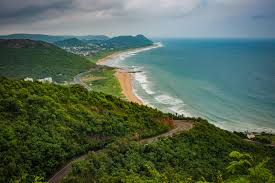
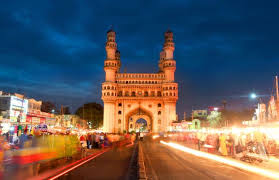
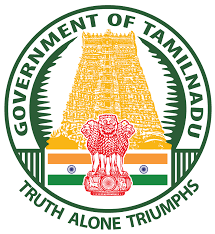
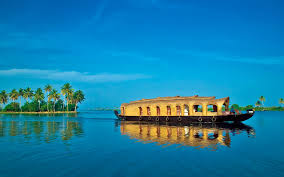
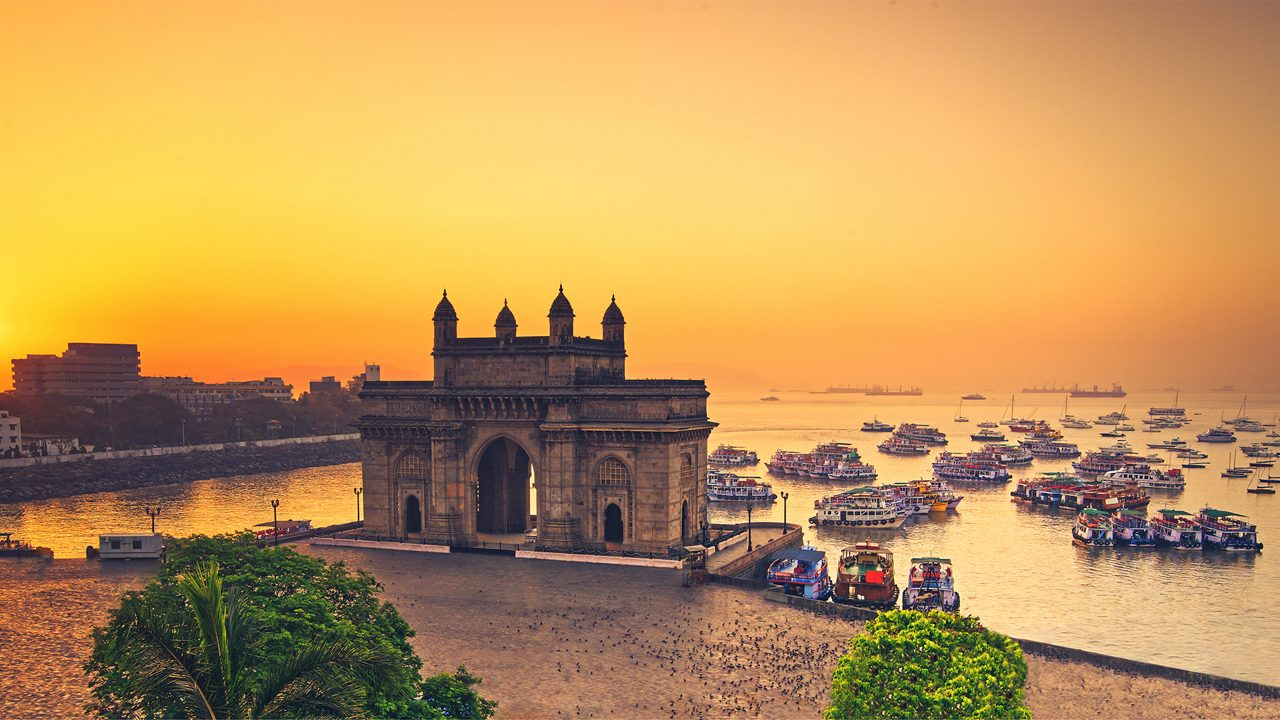
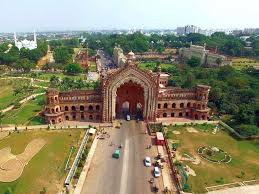
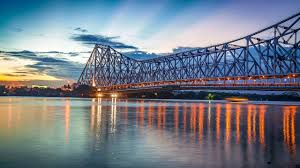
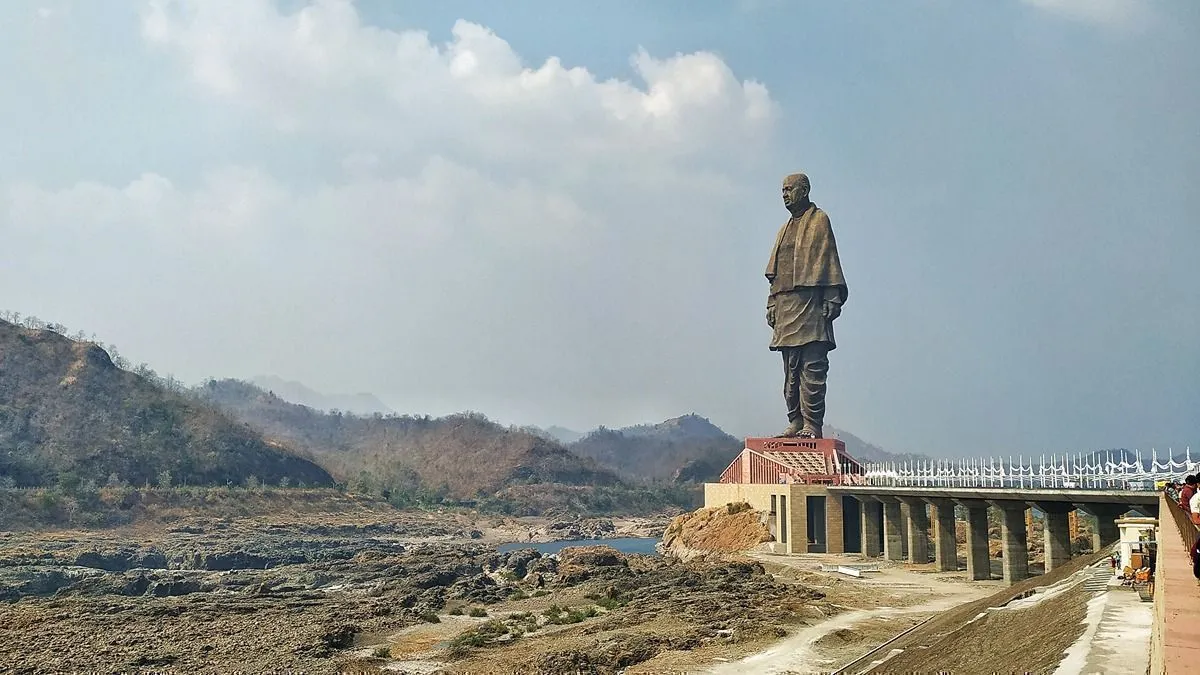
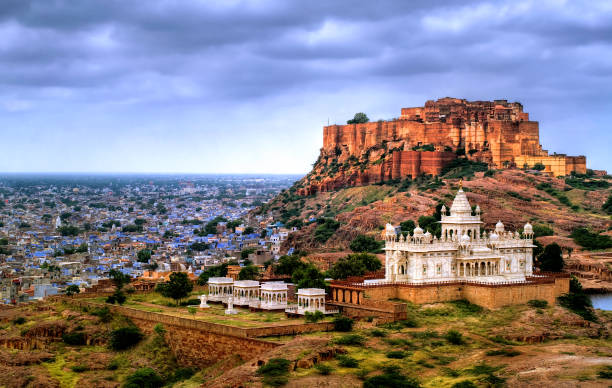
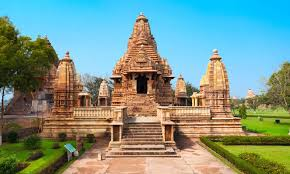
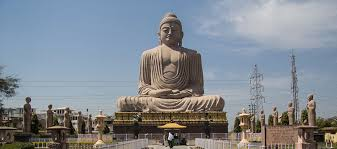
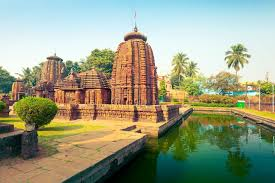
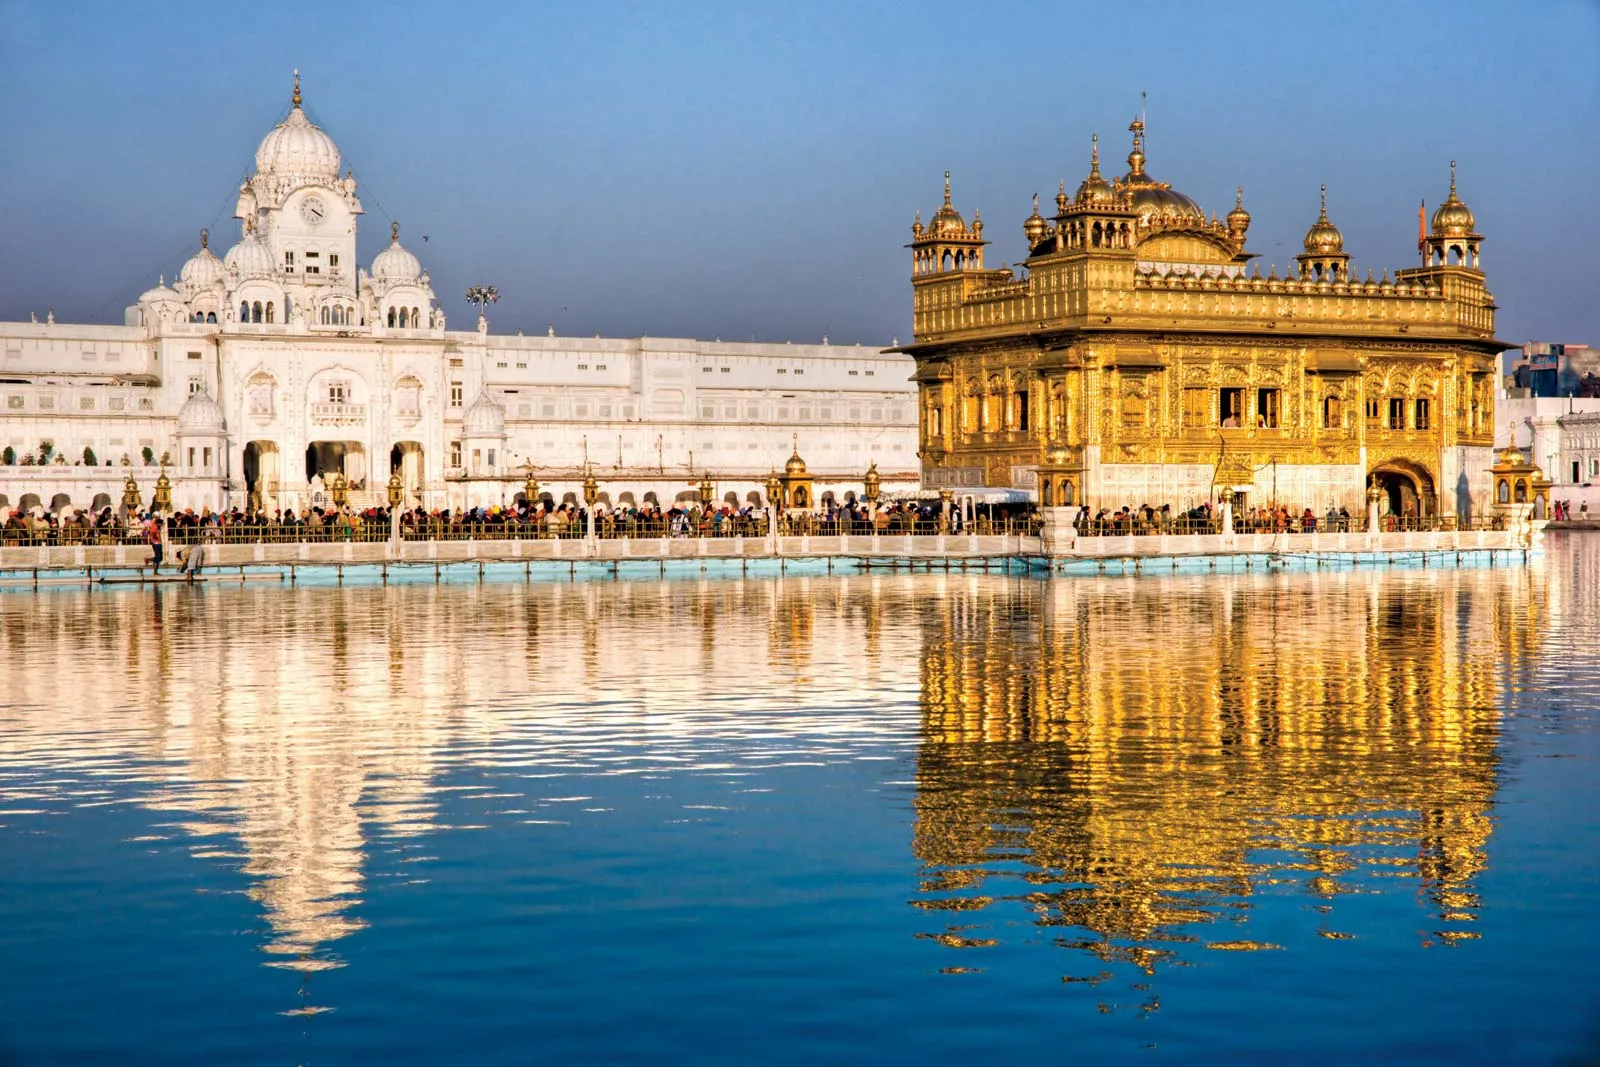

In [31]:
crime_map = folium.Map(location=[22.5, 78.9], zoom_start=5)

color_map = {
    "Low": "green",
    "Medium": "orange",
    "High": "red"
}

for _, row in df.iterrows():
    
    popup_html = f"""
    <h4>{row['State']}</h4>
    <img src="data:image/png;base64,{row['ImageBase64']}" width="220"><br><br>
    <b>Crime Risk Level:</b> {row['Risk_Level']}<br>
    <b>Total Crimes:</b> {row['Total_Crimes']}<br><br>
    <b>Description:</b><br>
    {row['Description']}
    """
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=8,
        color=color_map[row["Risk_Level"]],
        fill=True,
        fill_color=color_map[row["Risk_Level"]],
        fill_opacity=0.75,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=row["State"]
    ).add_to(crime_map)

crime_map


In [24]:
heat_map = folium.Map(
    location=[22.5, 78.9],
    zoom_start=5
)

heat_data = df[["Latitude", "Longitude", "Total_Crimes"]].values.tolist()

HeatMap(
    heat_data,
    radius=30,
    blur=20,
    max_zoom=1
).add_to(heat_map)

heat_map


In [25]:
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=6,
        popup=f"""
        <b>State:</b> {row['State']}<br>
        <b>Risk Level:</b> {row['Risk_Level']}
        """,
        color=color_map[row["Risk_Level"]],
        fill=True,
        fill_opacity=0.8
    ).add_to(heat_map)

heat_map


In [26]:
crime_map.save("India_Crime_Risk_map.html")
heat_map.save("India_Crime_Heatmap.html")
